In [1]:
## Keras configuration

# Set KERAS backend to Theano
import os
os.environ['KERAS_BACKEND']='theano'

# Load Keras
import keras

# Load the libraries
import numpy as np

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD

Using Theano backend.


In [2]:
import pandas as pd
from functools import reduce


In [3]:
# Load Data into array

nodes = []
for x in range(0, 5):
    nodes.append(pd.read_csv('https://raw.githubusercontent.com/Amitangshu/Irradiance_sensing/master/All_Data_For_EPIC_Roof/MDA300n' + str(x+150) +'.dat',
                     error_bad_lines=False, header=1))
    print("Loaded file MDA300n"+str(x+150)+".dat")

Loaded file MDA300n150.dat
Loaded file MDA300n151.dat
Loaded file MDA300n152.dat


b'Skipping line 47729: expected 7 fields, saw 13\n'


Loaded file MDA300n153.dat
Loaded file MDA300n154.dat


In [4]:
# Split TimeStamp into Date and Time columns and 

numNodes = len(nodes)
for y in range(numNodes):
    nodes[y][['DATE','TIME']] = nodes[y].TMSTAMP.str.split(expand=True)
    

In [5]:
for w in range(numNodes):
    nodes[w] = nodes[w].drop('TMSTAMP', 1)
    nodes[w] = nodes[w].drop('RECNBR', 1)
    nodes[w] = nodes[w].drop('PARENT', 1)
    nodes[w] = nodes[w].drop('SOLAROCV', 1)
    nodes[w] = nodes[w].drop('VBATT', 1)
    nodes[w] = nodes[w].drop('TEMP', 1)
    nodes[w] = nodes[w].drop('DATE', 1)

In [6]:
print(nodes[0].columns)


Index(['IRRADIANCE', 'TIME'], dtype='object')


In [7]:
# Explore data to see the distribution of irradiance values

count = []
for z in range(numNodes):
    count.append(nodes[z].IRRADIANCE.value_counts())
    

In [8]:
count[0].index


Float64Index([   2.92,    5.83,    8.75,   11.67,   20.42,   14.58,    35.0,
                 17.5,   55.41,   26.25,
              ...
              3094.41, 7151.27, 6602.96, 6675.88, 7256.26, 4742.24, 8026.22,
              1388.26, 3505.64, 2397.37],
             dtype='float64', length=2003)

In [9]:
# Select the 10 class values
class_values = [2.92, 8.75, 3.07, 2.81, 3.17, 8.44, 2.74, 2.98, 3.14, 3.52]


In [10]:
# Subset data by the selected class values

subset = []
for a in range(numNodes):
    subset.append(nodes[a][nodes[a].IRRADIANCE.isin(class_values)])
    

In [11]:
print(nodes[0].columns)


Index(['IRRADIANCE', 'TIME'], dtype='object')


In [12]:
# Merge the subsets

data = reduce(lambda  left,right: pd.merge(left,right,on=['IRRADIANCE','TIME'],how='outer'), nodes)


In [13]:
data.head()
print(data.size)


569638


In [14]:
# Transform Time column into numeric (hours)
data.TIME = pd.to_timedelta(data.TIME)
data.TIME = data.TIME.dt.seconds/3600


In [15]:
# Creating labels:

# Convert the labels into categorical classification
# Class values: {2.92, 8.75, 3.07, 2.81} correspond to {0, 1, 2, 3}
data.loc[data.IRRADIANCE==2.92, 'IRRADIANCE'] = 0
data.loc[data.IRRADIANCE==8.75, 'IRRADIANCE'] = 1
data.loc[data.IRRADIANCE==3.07, 'IRRADIANCE'] = 2
data.loc[data.IRRADIANCE==2.81, 'IRRADIANCE'] = 3
data.loc[data.IRRADIANCE==3.17, 'IRRADIANCE'] = 4
data.loc[data.IRRADIANCE==8.44, 'IRRADIANCE'] = 5
data.loc[data.IRRADIANCE==2.74, 'IRRADIANCE'] = 6
data.loc[data.IRRADIANCE==2.98, 'IRRADIANCE'] = 7
data.loc[data.IRRADIANCE==3.14, 'IRRADIANCE'] = 8
data.loc[data.IRRADIANCE==3.52, 'IRRADIANCE'] = 9


In [16]:
data.head()


,IRRADIANCE,TIME
0,40.83,18.887500
1,40.83,18.920000
2,17.50,19.066944
3,17.50,19.083056
4,14.58,19.099167


In [17]:
# Split data into three parts: training(40%), testing(30%), validation(30%)
# Use scikit-learn

import sklearn
from sklearn.model_selection import train_test_split

Train_Set, Test_Set = train_test_split(data, train_size=0.4, test_size=0.3, shuffle=True)


In [18]:
# Extract the feature columns: IRRADIANCE, TIME

X_train = np.array(Train_Set[['IRRADIANCE', 'TIME']]).astype('float64')
X_test = np.array(Test_Set[['IRRADIANCE','TIME']]).astype('float64')

# Input Shape
shape_ord = (X_train[0].shape)


In [19]:
# Extract the label column: IRRADIANCE

# Cast the label as integer
Y_train = np.array(Train_Set[['IRRADIANCE']]).astype('int')
Y_test = np.array(Test_Set[['IRRADIANCE']]).astype('int')

from keras.utils import to_categorical
# Convert the labels into categorical form
Y_train = to_categorical(Y_train, num_classes=8750)
Y_test = to_categorical(Y_test, num_classes=8750)


In [20]:
shape_ord


(2,)

### Training Model 1 - CNN

**1.** Initialize the parameters

In [21]:
# Initialize the parameters
# Number of epochs
nb_epochs = 1
# Batch size
batch_size = 128
# Vanilla SGD
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

**2.** Compile the model

In [22]:
model = Sequential()

model.add(Dense(10, activation='relu', input_dim=2))
model.add(Dropout(1.0))
model.add(Dense(10, activation='relu'))
model.add(Dropout(1.0))
model.add(Dense(8750, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                30        
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8750)              96250     
Total params: 96,390
Trainable params: 96,390
Non-trainable params: 0
_________________________________________________________________


**3.** Fit the model

In [23]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                30        
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8750)              96250     
Total params: 96,390
Trainable params: 96,390
Non-trainable params: 0
_________________________________________________________________


In [24]:
hist = model.fit(X_train, Y_train, batch_size=batch_size,validation_split=0.33, 
                 epochs=nb_epochs, verbose=1, 
                 validation_data=(X_test, Y_test))


Train on 113927 samples, validate on 85446 samples
Epoch 1/1
113927/113927 [==============================] - 142s 1ms/step - loss: 4.7798 - accuracy: 0.2105 - val_loss: 4.1495 - val_accuracy: 0.2556


**4.** Visualize the results

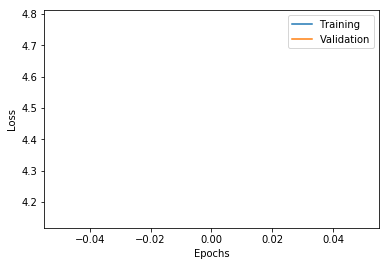

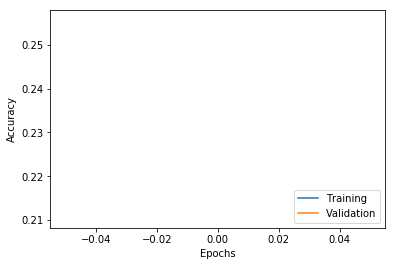

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['Training', 'Validation'], loc='lower right')


**5.** Evaluate the accuracy of the model

In [27]:
# Evaluating the model on the test data    
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)


Test Loss: 4.149542354525658
Test Accuracy: 0.25561171770095825


In [28]:
# Dropout Tests

# 1.0

model = Sequential()

model.add(Dense(10, activation='relu', input_dim=2))
model.add(Dropout(1.0))
model.add(Dense(10, activation='relu'))
model.add(Dense(8750, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

model.summary()

hist = model.fit(X_train, Y_train, batch_size=batch_size,validation_split=0.33, 
                 epochs=nb_epochs, verbose=1, 
                 validation_data=(X_test, Y_test))


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                30        
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 8750)              96250     
Total params: 96,390
Trainable params: 96,390
Non-trainable params: 0
_________________________________________________________________
Train on 113927 samples, validate on 85446 samples
Epoch 1/1
113927/113927 [==============================] - 130s 1ms/step - loss: 4.3466 - accuracy: 0.3163 - val_loss: 4.1967 - val_accuracy: 0.3268


In [29]:
# Dropout Tests

# 0.8

model = Sequential()

model.add(Dense(10, activation='relu', input_dim=2))
model.add(Dropout(0.8))
model.add(Dense(10, activation='relu'))
model.add(Dense(8750, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

model.summary()

hist = model.fit(X_train, Y_train, batch_size=batch_size,validation_split=0.33, 
                 epochs=nb_epochs, verbose=1, 
                 validation_data=(X_test, Y_test))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 10)                30        
_________________________________________________________________
dropout_4 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_9 (Dense)              (None, 8750)              96250     
Total params: 96,390
Trainable params: 96,390
Non-trainable params: 0
_________________________________________________________________
Train on 113927 samples, validate on 85446 samples
Epoch 1/1
113927/113927 [==============================] - 127s 1ms/step - loss: 4.7203 - accuracy: 0.1869 - val_loss: 4.6750 - val_accuracy: 0.2972


In [30]:
# Dropout Tests

# 0.6

model = Sequential()

model.add(Dense(10, activation='relu', input_dim=2))
model.add(Dropout(0.6))
model.add(Dense(10, activation='relu'))
model.add(Dense(8750, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

model.summary()

hist = model.fit(X_train, Y_train, batch_size=batch_size,validation_split=0.33, 
                 epochs=nb_epochs, verbose=1, 
                 validation_data=(X_test, Y_test))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 10)                30        
_________________________________________________________________
dropout_5 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_12 (Dense)             (None, 8750)              96250     
Total params: 96,390
Trainable params: 96,390
Non-trainable params: 0
_________________________________________________________________
Train on 113927 samples, validate on 85446 samples
Epoch 1/1
113927/113927 [==============================] - 128s 1ms/step - loss: 4.6213 - accuracy: 0.2440 - val_loss: 4.2362 - val_accuracy: 0.3342


In [31]:
# Dropout Tests

# 0.4

model = Sequential()

model.add(Dense(10, activation='relu', input_dim=2))
model.add(Dropout(0.4))
model.add(Dense(10, activation='relu'))
model.add(Dense(8750, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

model.summary()

hist = model.fit(X_train, Y_train, batch_size=batch_size,validation_split=0.33, 
                 epochs=nb_epochs, verbose=1, 
                 validation_data=(X_test, Y_test))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 10)                30        
_________________________________________________________________
dropout_6 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_15 (Dense)             (None, 8750)              96250     
Total params: 96,390
Trainable params: 96,390
Non-trainable params: 0
_________________________________________________________________
Train on 113927 samples, validate on 85446 samples
Epoch 1/1
113927/113927 [==============================] - 120s 1ms/step - loss: 4.4737 - accuracy: 0.2815 - val_loss: 4.2914 - val_accuracy: 0.2556


In [32]:
# Dropout Tests

# 0.2

model = Sequential()

model.add(Dense(10, activation='relu', input_dim=2))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu'))
model.add(Dense(8750, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

model.summary()

hist = model.fit(X_train, Y_train, batch_size=batch_size,validation_split=0.33, 
                 epochs=nb_epochs, verbose=1, 
                 validation_data=(X_test, Y_test))


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 10)                30        
_________________________________________________________________
dropout_7 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_18 (Dense)             (None, 8750)              96250     
Total params: 96,390
Trainable params: 96,390
Non-trainable params: 0
_________________________________________________________________
Train on 113927 samples, validate on 85446 samples
Epoch 1/1
113927/113927 [==============================] - 178s 2ms/step - loss: 4.3129 - accuracy: 0.3163 - val_loss: 4.1795 - val_accuracy: 0.3502


In [33]:
# Initialize the parameters
# Number of epochs
nb_epochs = 1
# Batch size
batch_size = 128
# Vanilla SGD
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

model = Sequential()

model.add(Dense(10, activation='relu', input_dim=2))
model.add(Dropout(1.0))
model.add(Dense(10, activation='relu'))
model.add(Dense(8750, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

model.summary()

hist = model.fit(X_train, Y_train, batch_size=batch_size,validation_split=0.33, 
                 epochs=nb_epochs, verbose=1, 
                 validation_data=(X_test, Y_test))


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 10)                30        
_________________________________________________________________
dropout_8 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_21 (Dense)             (None, 8750)              96250     
Total params: 96,390
Trainable params: 96,390
Non-trainable params: 0
_________________________________________________________________
Train on 113927 samples, validate on 85446 samples
Epoch 1/1
113927/113927 [==============================] - 117s 1ms/step - loss: 4.8271 - accuracy: 0.2946 - val_loss: 4.3133 - val_accuracy: 0.3230


In [34]:
#Dropout Tests Batch=32
# Initialize the parameters
# Number of epochs
nb_epochs = 1
# Batch size
batch_size = 32
# Vanilla SGD
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

model = Sequential()

model.add(Dense(10, activation='relu', input_dim=2))
model.add(Dropout(1.0))
model.add(Dense(10, activation='relu'))
model.add(Dense(8750, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

model.summary()

hist = model.fit(X_train, Y_train, batch_size=batch_size,validation_split=0.33, 
                 epochs=nb_epochs, verbose=1, 
                 validation_data=(X_test, Y_test))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 10)                30        
_________________________________________________________________
dropout_9 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_24 (Dense)             (None, 8750)              96250     
Total params: 96,390
Trainable params: 96,390
Non-trainable params: 0
_________________________________________________________________
Train on 113927 samples, validate on 85446 samples
Epoch 1/1
113927/113927 [==============================] - 158s 1ms/step - loss: 4.4593 - accuracy: 0.2577 - val_loss: 4.0823 - val_accuracy: 0.3268


In [35]:
#Dropout Tests Batch=64
# Initialize the parameters
# Number of epochs
nb_epochs = 1
# Batch size
batch_size = 64
# Vanilla SGD
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

model = Sequential()

model.add(Dense(10, activation='relu', input_dim=2))
model.add(Dropout(1.0))
model.add(Dense(10, activation='relu'))
model.add(Dense(8750, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

model.summary()

hist = model.fit(X_train, Y_train, batch_size=batch_size,validation_split=0.33, 
                 epochs=nb_epochs, verbose=1, 
                 validation_data=(X_test, Y_test))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 10)                30        
_________________________________________________________________
dropout_10 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_27 (Dense)             (None, 8750)              96250     
Total params: 96,390
Trainable params: 96,390
Non-trainable params: 0
_________________________________________________________________
Train on 113927 samples, validate on 85446 samples
Epoch 1/1
113927/113927 [==============================] - 134s 1ms/step - loss: 4.8707 - accuracy: 0.3176 - val_loss: 4.1084 - val_accuracy: 0.3230


In [36]:
#Dropout Tests Batch=256
# Initialize the parameters
# Number of epochs
nb_epochs = 1
# Batch size
batch_size = 256
# Vanilla SGD
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

model = Sequential()

model.add(Dense(10, activation='relu', input_dim=2))
model.add(Dropout(1.0))
model.add(Dense(10, activation='relu'))
model.add(Dense(8750, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

model.summary()

hist = model.fit(X_train, Y_train, batch_size=batch_size,validation_split=0.33, 
                 epochs=nb_epochs, verbose=1, 
                 validation_data=(X_test, Y_test))

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 10)                30        
_________________________________________________________________
dropout_11 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_30 (Dense)             (None, 8750)              96250     
Total params: 96,390
Trainable params: 96,390
Non-trainable params: 0
_________________________________________________________________
Train on 113927 samples, validate on 85446 samples
Epoch 1/1
113927/113927 [==============================] - 150s 1ms/step - loss: 5.4430 - accuracy: 0.3068 - val_loss: 4.8323 - val_accuracy: 0.3230


In [ ]:
#Dropout Tests Batch=16
# Initialize the parameters
# Number of epochs
nb_epochs = 1
# Batch size
batch_size = 16
# Vanilla SGD
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

model = Sequential()

model.add(Dense(10, activation='relu', input_dim=2))
model.add(Dropout(1.0))
model.add(Dense(10, activation='relu'))
model.add(Dense(8750, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

model.summary()

hist = model.fit(X_train, Y_train, batch_size=batch_size,validation_split=0.33, 
                 epochs=nb_epochs, verbose=1, 
                 validation_data=(X_test, Y_test))

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 10)                30        
_________________________________________________________________
dropout_12 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_33 (Dense)             (None, 8750)              96250     
Total params: 96,390
Trainable params: 96,390
Non-trainable params: 0
_________________________________________________________________
Train on 113927 samples, validate on 85446 samples
Epoch 1/1
113888/113927 [============================>.] - ETA: 0s - loss: 4.9189 - accuracy: 0.2001